In [10]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=20,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [11]:
import torch
from torch import nn
s = torch.rand(64,13,112,112)

encoder = nn.Conv2d(13, 20, kernel_size=(9,9), dilation=2)
q = encoder(s)
print(q.shape)
#q=torch.rand(64,20,96,96)

torch.Size([64, 20, 96, 96])


In [16]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

#model.segmentation_head=Identity()
r=model(q)
decoder=nn.AdaptiveAvgPool2d((112,112))
r = decoder(r)
r.shape

torch.Size([64, 1, 112, 112])

In [ ]:
decoder=nn.Conv2d(16,1,kernel_size)

In [61]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [6]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
    print("Not running in Google Colab.")

Not running in Google Colab.


In [22]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset, OfflineEgoDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [23]:
import os
from collections import Counter
from typing import Dict, Optional

import numpy as np
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.geometry import rotation33_as_yaw

# get config
cfg = load_config_data("../nmp/goal-config-debug.yaml")
print(cfg)
cfg["debug"] = True

{'format_version': 4, 'debug': False, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 4, 'future_num_frames': 12, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [112, 112], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'perturb_probability': 0.1}, 'val_data_loader': {'key': 'scenes/validate.zarr', 'batch_size': 64, 'shuffle': False, 'num_workers': 2}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'epochs': 1, 'eval_every_n_steps': 10000}}


In [9]:
dm = LocalDataManager()

rasterizer = build_rasterizer(cfg, dm)

preprocessed_dir = "/mnt/scratch/v_liuhaolan/preprocessed_goal"

from l5kit.dataset import CachedEgoDataset

train_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()
train_dataset = CachedEgoDataset(cfg, train_zarr, rasterizer, preprocessed_path=preprocessed_dir)


Debug: Read preprocessed dataset into memory...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 720.63it/s]


In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64,
#    num_workers=2           # using multiworkers cause serious hanging problems!
)

In [19]:
data_ego = next(iter(train_loader))

#print(data_ego)

image_tensor = data_ego["image"]
data_ego = torch.nn.functional.interpolate(image_tensor, size=(128,128))

idx = 12
print(data_ego.shape)

device = ("cuda:0")
#data_ego_cuda = {k: v.to(device) for k, v in data_ego.items()}

im_ego = rasterizer.to_rgb((data_ego[idx]).numpy().transpose(1, 2, 0))
#target_positions = transform_points(data_ego["target_positions"][idx].numpy(), data_ego["raster_from_agent"][0].numpy())

# weird hack
im_ego = np.ascontiguousarray(im_ego, dtype=np.uint8)

#draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
#target_positions = transform_points(traj['positions'].cpu().numpy(), data_ego["raster_from_agent"][0].numpy())

#draw_trajectory(im_ego, (target_positions).astype(np.uint8), TARGET_POINTS_COLOR)

#target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])

plt.imshow(im_ego)
plt.axis('off')
plt.show()

torch.Size([64, 13, 128, 128])


IndexError: boolean index did not match indexed array along dimension 0; dimension is 112 but corresponding boolean dimension is 128

In [20]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
root = "/mnt/data/v_liuhaolan"
#SimpleOxfordPetDataset.download(root)

Train size: 3312


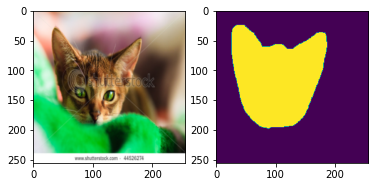

In [24]:
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")

print(f"Train size: {len(train_dataset)}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)


sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()


In [26]:
input_tensor = torch.tensor(sample["image"]).view(1,3,256,256).to("cuda:0")

from time import time
start = time()
q = torch.nn.functional.interpolate(input_tensor, size=(100,100))
print(time()-start)

print(q.shape)

0.0004799365997314453
torch.Size([1, 3, 100, 100])


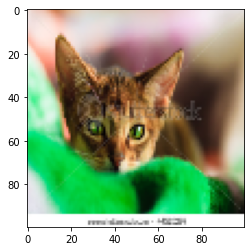

In [57]:
plt.imshow(q.squeeze().numpy().transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
